# COMP 135 Empirical/Programming Assignment 1

In [36]:
%matplotlib inline
import sys
import requests
import numpy as np
import matplotlib.pyplot as plt

## Task 3.1 Evaluating Decision Trees

export CLASSPATH=/r/aiml/ml-software/weka-3-6-11/weka.jar:$CLASSPATH

export WEKADATA=/r/aiml/ml-software/weka-3-6-11/data/

java weka.classifiers.trees.J48 -t ionosphere_train.arff -T ionosphere_test.arff

In [37]:
J48_ionosphere = 0.91453

java weka.classifiers.trees.J48 -t irrelevant_train.arff -T irrelevant_test.arff

In [38]:
J48_irrelevant = 0.645

java weka.classifiers.trees.J48 -t mfeat-fourier_train.arff -T mfeat-fourier_test.arff

In [39]:
J48_mfeat_fourier = 0.746627

java weka.classifiers.trees.J48 -t spambase_train.arff -T spambase_test.arff

In [40]:
J48_spambase = 0.915906

## Task 3.2 Reading Data Files

In [41]:
def read_arff(url):
    file = requests.get(url).content
    file = file.split('\n')
    sample = []
    for line in file:
        if line != "" and line[0].isdigit():
            line = line.strip("\n")
            line = line.split(',') 
            sample.append(line)
    for line in sample:
        for i in range(0, len(line)-1):
            line[i] = float(line[i])
    return sample

train_data_1 = read_arff("http://www.cs.tufts.edu/~roni/Teaching/ML/HW/pp1/pp1data/ionosphere_train.arff")
train_data_2 = read_arff("http://www.cs.tufts.edu/~roni/Teaching/ML/HW/pp1/pp1data/irrelevant_train.arff")
train_data_3 = read_arff("http://www.cs.tufts.edu/~roni/Teaching/ML/HW/pp1/pp1data/mfeat-fourier_train.arff")
train_data_4 = read_arff("http://www.cs.tufts.edu/~roni/Teaching/ML/HW/pp1/pp1data/spambase_train.arff")

test_data_1 = read_arff("http://www.cs.tufts.edu/~roni/Teaching/ML/HW/pp1/pp1data/ionosphere_test.arff")
test_data_2 = read_arff("http://www.cs.tufts.edu/~roni/Teaching/ML/HW/pp1/pp1data/irrelevant_test.arff")
test_data_3 = read_arff("http://www.cs.tufts.edu/~roni/Teaching/ML/HW/pp1/pp1data/mfeat-fourier_test.arff")
test_data_4 = read_arff("http://www.cs.tufts.edu/~roni/Teaching/ML/HW/pp1/pp1data/spambase_test.arff")

## Task 3.3 Implementing kNN

In [42]:
def split_label(data):
    example = []
    label = []
    for line in data:
        example.append(line[0:len(line)-1])
        label.append(line[len(line)-1])
    return np.array(example), np.array(label)

In [56]:
def kNN(test_data,train_data,k):
    
    train_points, train_labels = split_label(train_data)
    test_points, test_labels = split_label(test_data)
    
    test_labels_hat = []
    for point in test_points:
        distances = np.sqrt(np.sum((point - train_points)**2,1))
        ind = np.argsort(distances)[:k]
        
        vote = dict.fromkeys(set(train_labels),0)
        for indice in ind:
            vote[train_labels[indice]] += 1 
        test_labels_hat.append(max(vote, key = vote.get))
        
    accuracy = (sum(np.array(test_labels_hat) == np.array(test_labels)) + 0.0) / len(test_labels)
    return accuracy

## Task 3.4 Evaluating kNN with respect to k

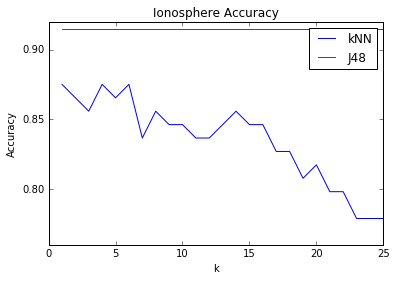

In [91]:
accuracy_vec = []
for k in range(1,26):
    accuracy = kNN(test_data_1, train_data_1, k)
    accuracy_vec.append(accuracy)
plt.plot(range(1,26),accuracy_vec,range(1,26),[J48_ionosphere]*25)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Ionosphere Accuracy')
plt.legend(["kNN","J48"])

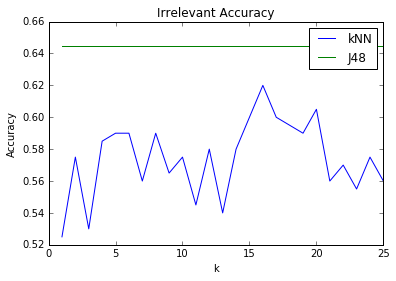

In [93]:
accuracy_vec = []
for k in range(1,26):
    accuracy = kNN(test_data_2, train_data_2, k)
    accuracy_vec.append(accuracy)
plt.plot(range(1,26),accuracy_vec,range(1,26),[J48_irrelevant] * 25)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Irrelevant Accuracy')
plt.legend(["kNN","J48"])

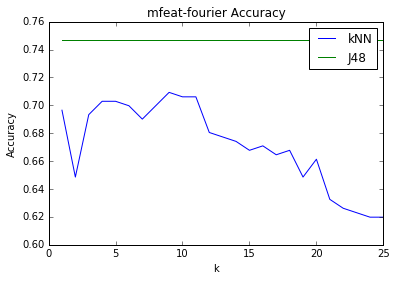

In [99]:
accuracy_vec = []
for k in range(1,26):
    accuracy = kNN(test_data_3, train_data_3, k)
    accuracy_vec.append(accuracy)
plt.plot(range(1,26),accuracy_vec,range(1,26),[J48_mfeat_fourier]*25)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('mfeat-fourier Accuracy')
plt.legend(["kNN","J48"])

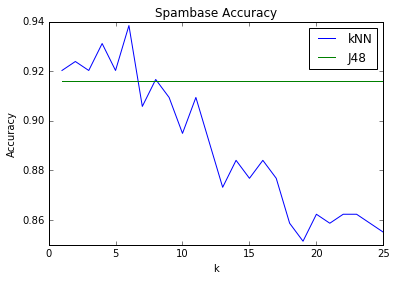

In [61]:
accuracy_vec = []
for k in range(1,26):
    accuracy = kNN(test_data_4, train_data_4, k)
    accuracy_vec.append(accuracy)
plt.plot(range(1,26),accuracy_vec,range(1,26),[J48_spambase]*25)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Spambase Accuracy')
plt.legend(["kNN","J48"])

### Discussion:

Except for spambase, J48 outperforms kNN over all the other data sets. In general, the accuracy of kNN would initially increase with the number of k then finally decreases for large values of k. There exist an optimal choice of k for kNN, whereas J48 has no parameter to choose.

## Task 3.5 Feature Selection for kNN

In [87]:
def compute_gain(train_data,i):
    
    feature = []
    train_points, train_labels = split_label(train_data)
    labels = set(train_labels)
    N = len(train_data)
    
    ind  = np.argsort(train_points[:,i])
    
    count = []
    gain = 0
    for l in labels:
        count.append(list(train_labels).count(l))
    for p in count:
        pk = (p + 0.0)/sum(count)
        if pk != 1 and pk != 0:
            gain += - pk * np.log2(pk)
    
    for k in range(0,5):
        ind_k = ind[k*N/5:(k+1)*N/5]
        count_k = []
        gain_k = 0
        for l in labels:
            count_k.append(list(train_labels[ind_k]).count(l))
        for p in count:
            pk = (p + 0.0)/sum(count_k)
            if pk != 1 and pk != 0:
                gain_k += - pk * np.log2(pk)
        gain += - ((len(ind_k)+0.0)/N) * gain_k
    return gain

In [106]:
def choose_feature(train_data,test_data,n):
    
    split_gain = []
    for i in range(0,len(train_data[0])-1):
        split_gain.append(compute_gain(train_data,i))
    ind = np.argsort(split_gain)[-n:]
    
    train_points, train_labels = split_label(train_data)
    test_points, test_labels = split_label(test_data)
    train_points = train_points[:,ind]
    test_points = test_points[:,ind]
    
    test_labels_hat = []
    for point in test_points:
        distances = np.sqrt(np.sum((point - train_points)**2,1))
        ind = np.argsort(distances)[:5]
        
        vote = dict.fromkeys(set(train_labels),0)
        for indice in ind:
            vote[train_labels[indice]] += 1 
        test_labels_hat.append(max(vote, key = vote.get))
        
    accuracy = (sum(np.array(test_labels_hat) == np.array(test_labels)) + 0.0) / len(test_labels)
    return accuracy

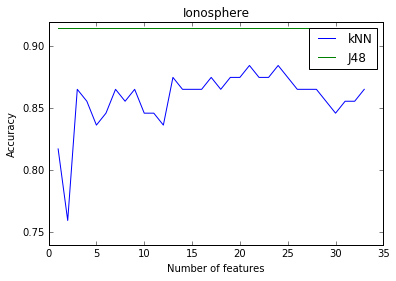

In [126]:
accuracy_vec = []
n_vec = np.arange(1,len(train_data_1[0])-1)
for n in n_vec:
    accuracy = choose_feature(train_data_1, test_data_1, n)
    accuracy_vec.append(accuracy)
plt.plot(n_vec, accuracy_vec, n_vec, [J48_ionosphere]*len(n_vec))
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title("Ionosphere")
plt.legend(["kNN","J48"])

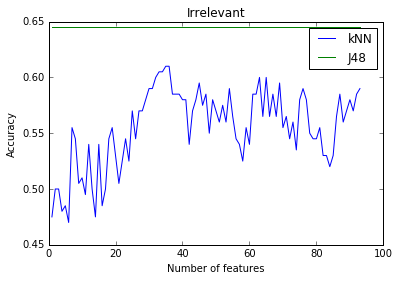

In [127]:
accuracy_vec = []
n_vec = np.arange(1,len(train_data_2[0])-1)
for n in n_vec:
    accuracy = choose_feature(train_data_2, test_data_2, n)
    accuracy_vec.append(accuracy)
plt.plot(n_vec, accuracy_vec, n_vec, [J48_irrelevant]*len(n_vec))
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title("Irrelevant")
plt.legend(["kNN","J48"])

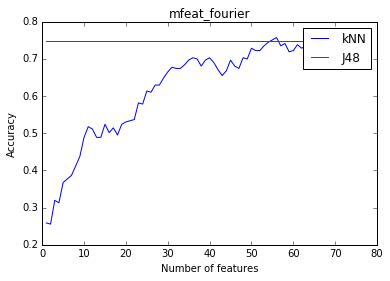

In [128]:
accuracy_vec = []
n_vec = np.arange(1,len(train_data_3[0])-1)
for n in n_vec:
    accuracy = choose_feature(train_data_3, test_data_3, n)
    accuracy_vec.append(accuracy)
plt.plot(n_vec, accuracy_vec, n_vec, [J48_mfeat_fourier]*len(n_vec))
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title("mfeat_fourier")
plt.legend(["kNN","J48"])

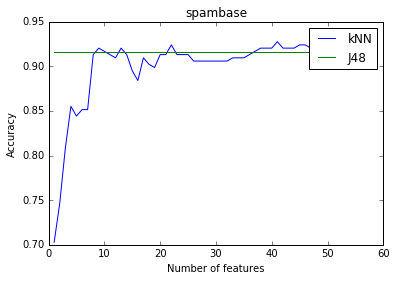

In [129]:
accuracy_vec = []
n_vec = np.arange(1,len(train_data_4[0])-1)
for n in n_vec:
    accuracy = choose_feature(train_data_4, test_data_4, n)
    accuracy_vec.append(accuracy)
plt.plot(n_vec, accuracy_vec, n_vec, [J48_spambase]*len(n_vec))
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title("spambase")
plt.legend(["kNN","J48"])

### Discussion:

In general, the performance of kNN increases with n, the number of features selected. For some values of n, kNN may outperfom J48. However, in practice, it is not feasible that we can automatically choose appropriate values for k and n for each dataset, because the perfomance of kNN is not monotonically increasing on n. For small n, the performance is not best because we are including too little information, and for large n, the performance is also not best because we are including too much information.